# Chapter 15

*Modeling and Simulation in Python*

Copyright 2021 Allen Downey

License: [Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International](https://creativecommons.org/licenses/by-nc-sa/4.0/)

In [1]:
# download modsim.py if necessary

from os.path import basename, exists

def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve
        local, _ = urlretrieve(url, filename)
        print('Downloaded ' + local)
    
download('https://github.com/AllenDowney/ModSimPy/raw/master/' +
         'modsim.py')

Downloaded modsim.py


In [2]:
# import functions from modsim

from modsim import *

This chapter is available as a Jupyter notebook where you can read the text, run the code, and work on the exercises. 
Click here to access the notebooks: <https://allendowney.github.io/ModSimPy/>.

So far the systems we have studied have been physical in the sense that they exist in the world, but they have not been physics in the sense of what physics classes are usually about. In the next few chapters, we'll do some physics, starting with *thermal systems*, that is, systems where the temperature of objects changes as heat transfers from one to another.

## The Coffee Cooling Problem

The coffee cooling problem was discussed by Jearl Walker in 
"The Amateur Scientist", *Scientific American*, Volume 237, Issue 5, November 1977. Since then it has become a standard example of modeling and simulation.

Here is my version of the problem:

> Suppose I stop on the way to work to pick up a cup of coffee, which I take with milk. Assuming that I want the coffee to be as hot as possible when I arrive at work, should I add the milk at the coffee shop, wait until I get to work, or add the milk at some point in between?

To help answer this question, I made a trial run with the milk and
coffee in separate containers and took some measurements (not really):

-   When served, the temperature of the coffee is 90 °C. The volume is
    300 mL.

-   The milk is at an initial temperature of 5 °C, and I take about
    50 mL.

-   The ambient temperature in my car is 22 °C.

-   The coffee is served in a well insulated cup. When I arrive at work after 30 minutes, the temperature of the coffee has fallen to 70 °C.

-   The milk container is not as well insulated. After 15 minutes, it
    warms up to 20 °C, nearly the ambient temperature.

To use this data and answer the question, we have to know something
about temperature and heat, and we have to make some modeling decisions.

## Temperature and Heat

To understand how coffee cools (and milk warms), we need a model of
temperature and heat. *Temperature* is a property of an object or a
system; in SI units it is measured in degrees Celsius (°C). Temperature quantifies how hot or cold the object is, which is related to the average velocity of the particles that make it up.

When particles in a hot object contact particles in a cold object, the
hot object gets cooler and the cold object gets warmer as energy is
transferred from one to the other. The transferred energy is called
*heat*; in SI units it is measured in joules (J).

Heat is related to temperature by the following equation (see
<http://modsimpy.com/thermass>): 

$$Q = C~\Delta T$$ 

where $Q$ is the amount of heat transferred to an object, $\Delta T$ is resulting change in temperature, and $C$ is the *thermal mass* of the object, which quantifies how much energy it takes to heat or cool it. In SI units, thermal mass is measured in joules per degree Celsius (J/°C).

For objects made primarily from one material, thermal mass can be
computed like this: 

$$C = m c_p$$ 

where $m$ is the mass of the object and $c_p$ is the *specific heat capacity* of the material (see <http://modsimpy.com/specheat>).

We can use these equations to estimate the thermal mass of a cup of
coffee. The specific heat capacity of coffee is probably close to that
of water, which is 4.2 J/g/°C. Assuming that the density of coffee is
close to that of water, which is 1 g/mL, the mass of 300 mL of coffee is 300 g, and the thermal mass is 1260 J/°C.

So when a cup of coffee cools from 90 °C to 70 °C, the change in
temperature, $\Delta T$ is 20 °C, which means that 25 200 J of heat
energy was transferred from the coffee to the surrounding environment
(the cup holder and air in my car).

To give you a sense of how much energy that is, if you were able to
harness all of that heat to do work (which you cannot), you could
use it to lift a cup of coffee from sea level to 8571 m, just shy of the height of Mount Everest, 8848 m.

Assuming that the cup has less mass than the coffee, and is made from a material with lower specific heat, we can ignore the thermal mass of the cup. For a cup with substantial thermal mass, like a ceramic mug, we might consider a model that computes the temperature of coffee and cup separately.

## Heat Transfer

In a situation like the coffee cooling problem, there are three ways
heat transfers from one object to another (see <http://modsimpy.com/transfer>):

-   Conduction: When objects at different temperatures come into
    contact, the faster-moving particles of the higher-temperature
    object transfer kinetic energy to the slower-moving particles of the lower-temperature object.

-   Convection: When particles in a gas or liquid flow from place to
    place, they carry heat energy with them. Fluid flows can be caused
    by external action, like stirring, or by internal differences in
    temperature. For example, you might have heard that hot air rises,
    which is a form of "natural convection".

-   Radiation: As the particles in an object move due to thermal energy,
    they emit electromagnetic radiation. The energy carried by this
    radiation depends on the object's temperature and surface properties
    (see <http://modsimpy.com/thermrad>).

For objects like coffee in a car, the effect of radiation is much
smaller than the effects of conduction and convection, so we will ignore it.

Convection can be a complex topic, since it often depends on details of fluid flow in three dimensions. But for this problem we will be able to get away with a simple model called "Newton's law of cooling".

## Newton's Law of Cooling

Newton's law of cooling asserts that the temperature rate of change for an object is proportional to the difference in temperature between the object and the surrounding environment:

$$\frac{dT}{dt} = -r (T - T_{env})$$ 

where $T$, the temperature of the object, is a function of time, $t$, $T_{env}$ is the temperature of the environment, and $r$ is a constant that characterizes how quickly heat is transferred between the system and the environment.

Newton's so-called "law " is really a model: it is a good approximation in some conditions and less good in others.

For example, if the primary mechanism of heat transfer is conduction,
Newton's law is "true", which is to say that $r$ is constant over a
wide range of temperatures. And sometimes we can estimate $r$ based on
the material properties and shape of the object.

When convection contributes a non-negligible fraction of heat transfer, $r$ depends on temperature, but Newton's law is often accurate enough, at least over a narrow range of temperatures. In this case $r$ usually has to be estimated experimentally, since it depends on details of surface shape, air flow, evaporation, etc.

When radiation makes up a substantial part of heat transfer, Newton's
law is not a good model at all. This is the case for objects in space or in a vacuum, and for objects at high temperatures (more than a few
hundred degrees Celsius, say).

However, for a situation like the coffee cooling problem, we expect
Newton's model to be quite good.

## Implementation

To get started, let's forget about the milk temporarily and focus on the coffee.
Here's a function that takes the parameters of the system and makes a `System` object:

In [3]:
def make_system(T_init, volume, r, t_end):
    return System(T_init=T_init,
                  T_final=T_init,
                  volume=volume,
                  r=r,
                  t_end=t_end,
                  T_env=22,
                  t_0=0,
                  dt=1)

In addition to the parameters, `make_system` sets the temperature of the environment, `T_env`, the initial time stamp, `t_0`, and the time step, `dt`, which we will use use to simulate the cooling process.
Here's a `System` object that represents the coffee.

In [4]:
coffee = make_system(T_init=90, volume=300, r=0.01, t_end=30)

The values of `T_init`, `volume`, and `t_end` come from the statement of the problem.
I chose the value of `r` arbitrarily for now; we will see how to estimate it soon.

Strictly speaking, Newton's law is a differential equation, but over a short period of time we can approximate it with a difference equation:

$$\Delta T = -r (T - T_{env}) dt$$ 

where $dt$ is the time step and $\Delta T$ is the change in temperature during that time step.

Note: I use $\Delta T$ to denote a change in temperature over time, but in the context of heat transfer, you might also see $\Delta T$ used to denote the difference in temperature between an object and its
environment, $T - T_{env}$. To minimize confusion, I avoid this second
use.

The following function takes the current time `t`, the current temperature, `T`, and a `System` object, and computes the change in temperature during a time step:

In [5]:
def change_func(t, T, system):
    r, T_env, dt = system.r, system.T_env, system.dt    
    return -r * (T - T_env) * dt

We can test it with the initial temperature of the coffee, like this:

In [6]:
change_func(0, coffee.T_init, coffee)

-0.68

With `dt=1` minute, the temperature drops by about 0.7 °C, at least for this value of `r`.

Now here's a version of `run_simulation` that simulates a series of time steps from `t_0` to `t_end`:

In [7]:
def run_simulation(system, change_func):
    t_array = linrange(system.t_0, system.t_end, system.dt)
    n = len(t_array)
    
    series = TimeSeries(index=t_array)
    series.iloc[0] = system.T_init
    
    for i in range(n-1):
        t = t_array[i]
        T = series.iloc[i]
        series.iloc[i+1] = T + change_func(t, T, system)
    
    system.T_final = series.iloc[-1]
    return series

There are a two things here that are different from previous versions of `run_simulation`.

First, we use  `linrange` to make an array of values from `t_0` to `t_end` with time step `dt`.  
`linrange` is similar to `linspace`; they both take a start value and an end value and return an array of equally spaced values.
The difference is the third argument: `linspace` takes an integer that indicates the number of points in the range; `linrange` takes a step size that indicates the interval between values.
When we make the `TimeSeries`, we use the keyword argument `index` to indicate that the index of the `TimeSeries` is the array of time stamps, `t_array`.

Second, this version of `run_simulation` uses `iloc` rather than `loc` to specify the rows in the `TimeSeries`.
Here's the difference: 

* With `loc`, the label in brackets can be any kind of value, with any start, end, and time step.  For example, in the world population model, the labels are years starting in 1960 and ending in 2016.

* With `iloc`, the label in brackets is always an integer starting at 0.  So we can always get the first element with `iloc[0]` and the last element with `iloc[-1]`, regardless of what the labels are.

In this version of `run_simulation`, the loop variable is an integer, `i`, that goes from `0` to `n-1`, including `0` but not including `n-1`.
So the first time through the loop, `i` is `0` and the value we add to the `TimeSeries` has index 1.
The last time through the loop, `i` is `n-2` and the value we add has index `n-1`.

We can run the simulation like this:

In [8]:
results = run_simulation(coffee, change_func)

The result is a `TimeSeries` with one row per time step. 
Here are the first few rows:

In [9]:
show(results.head())

,Quantity
Time,
0.0,90.000000
1.0,89.320000
2.0,88.646800
3.0,87.980332
4.0,87.320529


And the last few rows:

In [10]:
show(results.tail())

,Quantity
Time,
26.0,74.362934
27.0,73.839305
28.0,73.320912
29.0,72.807702
30.0,72.299625


With `t_0=0`, `t_end=30`, and `dt=1`, the time stamps go from `0.0` to `30.0`.

Here's what the `TimeSeries` looks like.

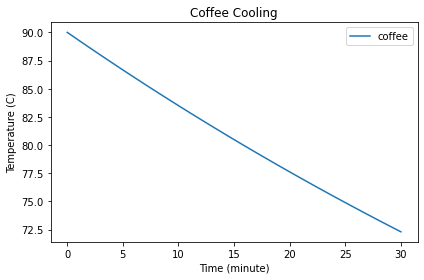

In [11]:
results.plot(label='coffee')

decorate(xlabel='Time (minute)',
         ylabel='Temperature (C)',
         title='Coffee Cooling')

The temperature after 30 minutes is 72.3 °C, which is a little higher than what's stated in the problem, 70 °C. 

In [12]:
coffee.T_final

72.2996253904031

By trial and error, we could find the value of `r` where the final temperature is precisely 70 °C.
But it is more efficient to use a root-finding algorithm.

## Finding Roots

The ModSim library provides a function called `root_scalar` that finds the roots of non-linear equations. As an example, suppose you want to find the roots of the polynomial 

$$f(x) = (x - 1)(x - 2)(x - 3)$$ 

A *root* is a value of $x$ that makes $f(x)=0$. Because of the way I wrote this polynomial, we can see that if $x=1$, the first factor is 0; if $x=2$, the second factor is 0; and if $x=3$, the third factor is 0, so those are the roots.

I'll use this example to demonstrate `root_scalar`. First, we have to
write a function that evaluates $f$:

In [13]:
def func(x):
    return (x-1) * (x-2) * (x-3)

Now we call `root_scalar` like this:

In [14]:
res = root_scalar(func, bracket=[1.5, 2.5])
res

      converged: True
           flag: 'converged'
 function_calls: 3
     iterations: 2
           root: 2.0

The first argument is the function whose roots we want. The second
argument is an interval that contains or "brackets" a root. The result is an object that contains several variables, including `root`, which is the root that was found.

In [15]:
res.root

2.0

If we provide a different interval, we find a different root.

In [16]:
res = root_scalar(func, bracket=[2.5, 3.5])
res.root

2.9999771663211003

If the interval doesn't contain a root, you'll get a `ValueError` and a message like "f(a) and f(b) must have different signs".

```
res = root_scalar(func, bracket=[4, 5])
```

Now we can use `root_scalar` to estimate `r`.

## Estimating `r`

What we want is the value of `r` that yields a final temperature of
70 °C. To use `root_scalar`, we need a function that takes `r` as a parameter and returns the difference between the final temperature and the goal:

In [17]:
def error_func(r, system):
    system.r = r
    results = run_simulation(system, change_func)
    return system.T_final - 70

This is called an "error function" because it returns the
difference between what we got and what we wanted, that is, the error.
With the right value of `r`, the error is 0.

We can test `error_func` like this, using the initial guess `r=0.01`:

In [18]:
coffee = make_system(T_init=90, volume=300, r=0.01, t_end=30)
error_func(0.01, coffee)

2.2996253904030937

The result is an error of 2.3 °C, which means the final temperature with `r=0.01` is too high.

In [19]:
error_func(0.02, coffee)

-10.907066281994297

With `r=0.02`, the error is  about -11°C, which means that the final temperature is too low. So we know that the correct value must be in between.

Now we can call `root_scalar` like this:

In [20]:
res = root_scalar(error_func, coffee, bracket=[0.01, 0.02])
res.flag

'converged'

The first argument is the error function.
The second argument is the `System` object, which `root_scalar` passes as an argument to `error_func`.
The third argument is an interval that brackets the root.

Here are the results.

In [21]:
r_coffee = res.root
r_coffee

0.011543084190599507

In this example, `r_coffee` turns out to be about `0.0115`, in units of min$^{-1}$ (inverse minutes).
We can confirm that this value is correct by setting `r` to the root we found and running the simulation.

In [22]:
coffee.r = res.root
run_simulation(coffee, change_func)
coffee.T_final

70.00000057308064

The final temperature is very close to 70 °C.

## Exercises

### Exercise 1

Simulate the temperature of 50 mL of milk with a starting temperature of 5 °C, in a vessel with `r=0.1`, for 15 minutes, and plot the results.
By trial and error, find a value for `r` that makes the final temperature close to 20 °C.

In [24]:
# Solution goes here
milk = make_system(T_init = 5, volume = 50, r = 0.1, t_end = 15)
results = run_simulation(milk, change_func)

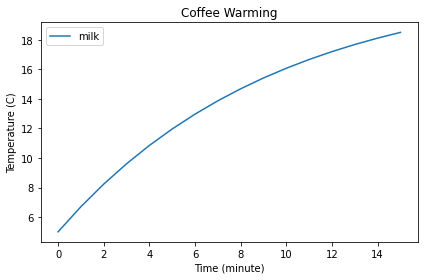

In [26]:
# Solution goes here
results.plot(label='milk')

decorate(xlabel='Time (minute)',
         ylabel='Temperature (C)',
         title='Coffee Warming')

### Exercise 2

Write an error function that simulates the temperature of the milk and returns the difference between the final temperature and 20 °C.  Use it to estimate the value of `r` for the milk.

In [27]:
# Solution goes here
def error_func(r, system):
    system.r = r
    results = run_simulation(system, change_func)
    return system.T_final - 20

In [30]:
# Solution goes here

# with r = 0.1 we are about 1.5 degrees below the target
error_func(0.1, milk)

-1.500149245609034

In [31]:
# with r = 0.2 we are about 1.4 degrees above the target
error_func(0.2, milk)

1.4018656744898585

In [32]:
# Solution goes here

# We know that r should be between 0.1 and 0.2 because the range of difference crosses zero
res = root_scalar(error_func, milk, bracket=[0.1, 0.2])
res.root

0.1329607815660008

In [33]:
# check the calculated root value
milk.r = res.root
run_simulation(milk, change_func)
milk.T_final

19.99999973050824